<a href="https://colab.research.google.com/github/vfrantc/covidpa/blob/main/eda_covid_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [44]:
!wget https://raw.githubusercontent.com/vfrantc/covidpa/main/data.csv

--2020-12-23 19:27:26--  https://raw.githubusercontent.com/vfrantc/covidpa/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5815168 (5.5M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   5.54M  28.7MB/s    in 0.2s    

2020-12-23 19:27:27 (28.7 MB/s) - ‘data.csv.1’ saved [5815168/5815168]



In [45]:
df = pd.read_csv('data.csv')
del df['Unnamed: 0']

In [46]:
df.head()

,ids,theta1,theta2,t,new_contagious,new_severe,new_dead
0,0,0.0,0,0,28,0,0
1,0,0.0,0,1,5,0,0
2,0,0.0,0,2,4,0,0
3,0,0.0,0,3,1,0,0
4,0,0.0,0,4,2,1,0


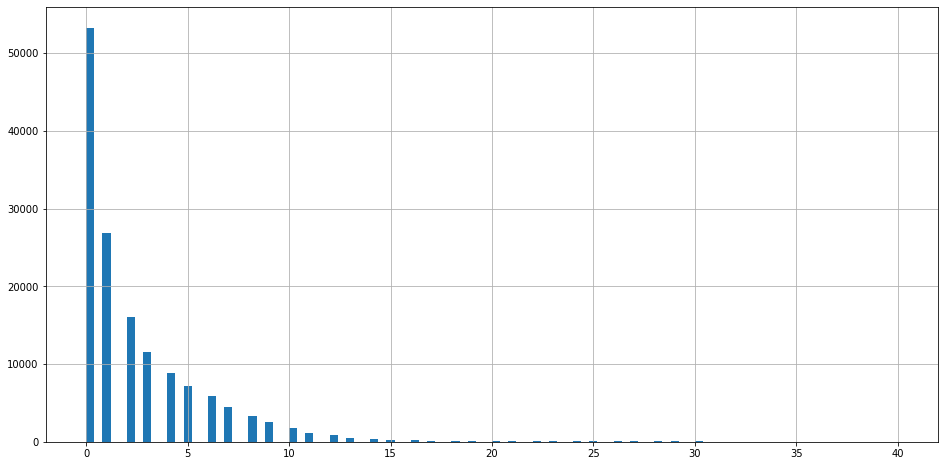

In [47]:
df.new_contagious.hist(bins=100, figsize=(16, 8))

In [48]:
# location and scale
expon.fit(df.new_contagious.ravel())

(0.0, 2.6011836578846887)

In [49]:
X = []
y = []

In [50]:
win_size = 14
for myid, simulation in df.groupby('ids'):
  new_contagious = simulation['new_contagious'].ravel()
  new_severe = simulation['new_severe'].ravel()
  new_contagious = np.pad(new_contagious, pad_width=(win_size-1, 0))
  for i in range(len(new_severe)):
    y.append(new_severe[i])
    X.append(new_contagious[i:(i+win_size)])

In [51]:
X[0], y[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28]), 0)

In [52]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))



Linear: 0.222 ([0.21951932 0.22566303 0.20899507 0.22729629 0.22673468])
Ridge: 0.222 ([0.21586703 0.22664776 0.22094887 0.22351698 0.22109654])
Lasso: -0.000 ([-9.79000613e-05 -8.79657967e-07 -3.43218092e-07 -7.00233417e-06
 -4.53618167e-05])
Elastic: 0.135 ([0.1331897  0.13323843 0.13537358 0.13583318 0.13599785])


In [54]:
model = LinearRegression().fit(X, y)

In [55]:
model.coef_

array([-1.33954944e-03,  8.92882299e-05,  4.02847485e-03,  4.03902919e-03,
        6.36561104e-03,  8.43052820e-03,  1.13886113e-02,  1.60833137e-02,
        1.95132551e-02,  2.67180288e-02,  1.67092903e-03,  2.66874629e-03,
        3.20820041e-03,  3.54900713e-03])

In [57]:
model.intercept_

0.0022841226785017543

In [53]:
poly = PolynomialFeatures(2)
X_ = poly.fit_transform(X)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X_, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.252 ([0.25478124 0.24483665 0.25409194 0.25164098 0.25292471])
Ridge: 0.252 ([0.253268   0.25606892 0.24771679 0.25707679 0.24370698])
Lasso: 0.223 ([0.21520951 0.22125306 0.2225676  0.23494108 0.22276434])
Elastic: 0.227 ([0.23081374 0.22146772 0.22111681 0.22709877 0.2336273 ])


In [58]:
model = LinearRegression().fit(X_, y)

In [59]:
model.coef_

array([ 9.03008077e-19, -2.13479392e-03,  7.57963895e-04,  5.92652328e-03,
        5.36240411e-03,  6.69832542e-03,  7.85889285e-03,  1.28709239e-02,
        1.11141110e-02,  1.61972703e-02,  1.88358039e-02,  5.26370756e-03,
        6.74641795e-03,  3.48855305e-03, -1.02181847e-04,  1.12591270e-03,
       -4.50001708e-04, -1.98935081e-04, -6.96081972e-04,  6.10131827e-06,
       -8.22753722e-05,  7.77975032e-05, -3.87614013e-04,  4.08387525e-04,
       -8.05198117e-06, -1.69493942e-04, -5.91011109e-05, -2.71535504e-04,
       -5.52336447e-05,  1.05968467e-03, -3.81053002e-04, -7.43304947e-05,
       -3.91863041e-04, -4.29091980e-04,  3.07421406e-04, -4.79581543e-05,
       -8.41989263e-04, -2.29569579e-04, -5.15327846e-04,  1.80602097e-04,
        2.05952900e-04, -3.11005517e-04,  6.18022297e-04, -6.29924708e-04,
       -2.92367645e-04, -3.09378515e-04, -1.91105041e-04,  1.23929943e-04,
       -1.76655865e-05, -2.43428397e-04,  1.56039817e-04,  1.10056042e-04,
        3.58746977e-04, -

In [60]:
model.intercept_

-0.0029794670492998554